In [1]:
import re
import string
import csv
import snscrape.modules.twitter as sntwitter
# import demoji
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

preprocessed_dataset = pd.read_csv("fix_dataset.csv")
preprocessed_dataset

,date,renderedContent,preprocessed
0,2022-12-30 23:59:46+00:00,@prabususatya @Reiza_Patters @ganjarpranowo Ke...,kelakuan kader partai demokrasi indonesia perj...
1,2022-12-30 23:52:00+00:00,@GPJateng @PDI_Perjuangan Gila lu duit Ummat b...,gila duit umat kader pendukung junjunganlu cov...
2,2022-12-30 23:51:36+00:00,@YanHarahap @SBYudhoyono @jokowi Nah setelah b...,banyaknya pengeluaran dana covid ya indonesia ...
3,2022-12-30 23:50:49+00:00,"Presiden Jokowi Cabut PPKM, Bagaimana Nasib Ba...",presiden jokowi pergi ppkm nasib bansos
4,2022-12-30 23:48:57+00:00,@YanHarahap @SBYudhoyono @jokowi Jadi sektor.e...,sektor ekinomi merosot usaha mikro menengah ra...
...,...,...,...
3762,2022-12-21 09:53:46+00:00,"Tetanggaku, janda sepuh. U/ bertahan hidup saj...",tetanggaku janda sepuh be ahan hidup mengandal...
3763,2022-12-21 09:42:38+00:00,surat terbuka kpd yth ibu mensos kadinsos kab....,surat terbuka terhormat menteri sosial kadinso...
3764,2022-12-21 09:37:57+00:00,@Noahpinion does it at least look pretty?,does it at least look pretty
3765,2022-12-21 08:30:44+00:00,@Fendy_Garp @gibran_tweet Iyo tonggomu mungkin...,iya tonggomu trdftar program keluarga harapan ...


In [7]:
sequence_length = []
for text in preprocessed_dataset.preprocessed.values:
    sequence_length.append(len(str(text).split(" ")))
preprocessed_dataset["sequence length"] = sequence_length
preprocessed_dataset = preprocessed_dataset[preprocessed_dataset["sequence length"] > 5]
preprocessed_dataset = preprocessed_dataset.drop(["sequence length"], axis=1)
preprocessed_dataset = preprocessed_dataset.reset_index(drop=True)
preprocessed_dataset


,date,renderedContent,preprocessed
0,2022-12-30 23:59:46+00:00,@prabususatya @Reiza_Patters @ganjarpranowo Ke...,kelakuan kader partai demokrasi indonesia perj...
1,2022-12-30 23:52:00+00:00,@GPJateng @PDI_Perjuangan Gila lu duit Ummat b...,gila duit umat kader pendukung junjunganlu cov...
2,2022-12-30 23:51:36+00:00,@YanHarahap @SBYudhoyono @jokowi Nah setelah b...,banyaknya pengeluaran dana covid ya indonesia ...
3,2022-12-30 23:50:49+00:00,"Presiden Jokowi Cabut PPKM, Bagaimana Nasib Ba...",presiden jokowi pergi ppkm nasib bansos
4,2022-12-30 23:48:57+00:00,@YanHarahap @SBYudhoyono @jokowi Jadi sektor.e...,sektor ekinomi merosot usaha mikro menengah ra...
...,...,...,...
3762,2022-12-21 09:53:46+00:00,"Tetanggaku, janda sepuh. U/ bertahan hidup saj...",tetanggaku janda sepuh be ahan hidup mengandal...
3763,2022-12-21 09:42:38+00:00,surat terbuka kpd yth ibu mensos kadinsos kab....,surat terbuka terhormat menteri sosial kadinso...
3764,2022-12-21 09:37:57+00:00,@Noahpinion does it at least look pretty?,does it at least look pretty
3765,2022-12-21 08:30:44+00:00,@Fendy_Garp @gibran_tweet Iyo tonggomu mungkin...,iya tonggomu trdftar program keluarga harapan ...


### TFIDF ###

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import pandas as pd

tfidf = TfidfVectorizer()

tweet_data = tfidf.fit_transform(preprocessed_dataset.tweet.values)
tweet_data = pd.DataFrame(tweet_data.todense())
tweet_data = tweet_data.fillna(0)

bestfeatures = SelectKBest(score_func=chi2, k=100)
bestfeatures.fit(tweet_data, preprocessed_dataset.tweet)

X = bestfeatures.transform(tweet_data)
print(X.shape)

(3767, 100)


### GENSIM ###

In [8]:
import gensim
import numpy as np
from gensim.models.fasttext import load_facebook_model

fasttext = gensim.models.fasttext.load_facebook_model("Fastext_model_tweet.bin")
print("Ada %s vektor kata yang ditemukan dalam model FastText" % len(fasttext.wv))

"""_Merepresentasikan setiap tweet ke dalam vektor bilangan real_"""

vectors = []
for text in preprocessed_dataset.preprocessed.values:
    word_embedding = []
    for word in text.split(" "):
        try:
            word_vec = fasttext.wv[word]
            word_embedding.append(word_vec)
        except:
            pass
    word_embedding = np.array(word_embedding)
    embeddings = np.mean(word_embedding, axis=0)
    vectors.append(embeddings)
vectors = np.array(vectors)
print("Dimensi dari fitur yang digunakan yaitu", (vectors.shape))

Ada 69465 vektor kata yang ditemukan dalam model FastText
Dimensi dari fitur yang digunakan yaitu (3767, 100)


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_PCA = pca.fit_transform(vectors)

In [12]:
from time import time
import joblib

start = time()
loaded_model = joblib.load("SVMRBF_model.sav")
Y_pred = loaded_model.predict(X_PCA)
# acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start

print(Y_pred)
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))

['sadness' 'sadness' 'love' ... 'sadness' 'happy' 'happy']
Lama waktu yang dibutuhkan untuk memproses yaitu 0.21 detik.


In [13]:
preprocessed_dataset['label'] = Y_pred
result = preprocessed_dataset.copy()

In [14]:
preprocessed_dataset.head()

,date,renderedContent,preprocessed,label
0,2022-12-30 23:59:46+00:00,@prabususatya @Reiza_Patters @ganjarpranowo Ke...,kelakuan kader partai demokrasi indonesia perj...,sadness
1,2022-12-30 23:52:00+00:00,@GPJateng @PDI_Perjuangan Gila lu duit Ummat b...,gila duit umat kader pendukung junjunganlu cov...,sadness
2,2022-12-30 23:51:36+00:00,@YanHarahap @SBYudhoyono @jokowi Nah setelah b...,banyaknya pengeluaran dana covid ya indonesia ...,love
3,2022-12-30 23:50:49+00:00,"Presiden Jokowi Cabut PPKM, Bagaimana Nasib Ba...",presiden jokowi pergi ppkm nasib bansos,happy
4,2022-12-30 23:48:57+00:00,@YanHarahap @SBYudhoyono @jokowi Jadi sektor.e...,sektor ekinomi merosot usaha mikro menengah ra...,sadness


In [35]:
preprocessed_dataset.to_csv('fix_dataset_label.csv')

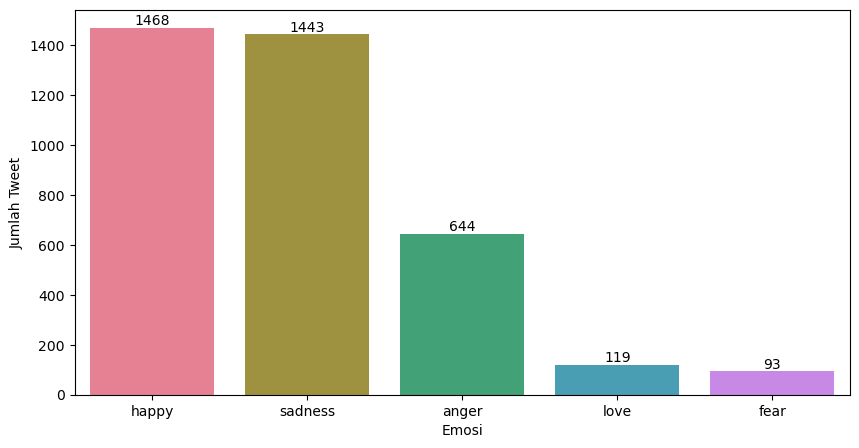

In [15]:
import seaborn as sns

figure, ax = plt.subplots(figsize=(10, 5))
number = [count for count in preprocessed_dataset.label.value_counts()]
labels = list(preprocessed_dataset.label.value_counts().index)
sns.barplot(x=labels, y=number, palette="husl")
ax.set_xlabel("Emosi")
ax.set_ylabel("Jumlah Tweet")
ax.bar_label(ax.containers[0])
plt.show()

In [16]:
preprocessed_dataset.renderedContent[160]

'Pemkab Bangka Tengah salurkan bansos tunai kepada\xa0nelayan https://t.co/3jrAjJrJYt'

In [17]:
preprocessed_dataset.label[160]

'anger'

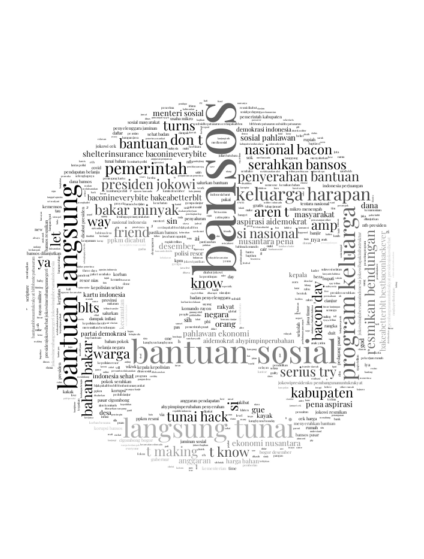

In [18]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

anger_tweets = result[result.label == "anger"]
anger_tweets = anger_tweets.reset_index(drop=True)
list_of_words = ""
for word in anger_tweets.preprocessed:
    word = str(word)
    word = word.replace("BLT", "")
    word = word.split()
    list_of_words += " ".join(word) + " "
    
mask = np.array(Image.open("anger.png"))
font = "PlayfairDisplay-Regular.ttf"
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, font_path=font, mask=mask).generate(list_of_words)
color = ImageColorGenerator(mask)
plt.figure(figsize=(7, 7))
plt.imshow(wordcloud.recolor(color_func=color), interpolation="bilinear")
plt.axis("off")
plt.show()

In [79]:
X = vectors
Y = np.array(preprocessed_dataset.label)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

random_forest = RandomForestClassifier()

"""_Melatih model Random Forest menggunakan train data_"""

random_forest.fit(X_train, Y_train)
filename = "SVMRBF_model.sav"
joblib.dump(random_forest, filename)

"""_Menguji model Random Forest menggunakan test data_"""

start = time()
loaded_model = joblib.load("RF.sav")
Y_pred = loaded_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
end = time()
elapsed = end - start
print("Akurasi yang dihasilkan pada proses pengujian adalah %.2f%%\n" % (acc_score*100))
print("Dan berikut merupakan hasil evaluasi secara keseluruhan:\n\n", classification_report(Y_test, Y_pred))
print("Lama waktu yang dibutuhkan untuk memproses yaitu %.2f detik." % (elapsed))


Akurasi yang dihasilkan pada proses pengujian adalah 59.44%

Dan berikut merupakan hasil evaluasi secara keseluruhan:

               precision    recall  f1-score   support

       anger       0.60      0.72      0.65       103
        fear       0.68      0.43      0.53        69
       happy       0.56      0.64      0.59        91
        love       0.78      0.67      0.72        69
     sadness       0.48      0.48      0.48        97

    accuracy                           0.59       429
   macro avg       0.62      0.59      0.60       429
weighted avg       0.61      0.59      0.59       429

Lama waktu yang dibutuhkan untuk memproses yaitu 0.14 detik.
